# Comparing CAMB with CLASS: DM-DE interaction 
#### CDM, Photons and Metric

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import camb
from scipy.interpolate import interp1d
import os
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.8 installed at /home/user/CAMB-iDEDM/camb


In [2]:
gauge = 'Newtonian' # or 'Newtonian' (in CAMB syntax)
kscale = 0.1

In [3]:
# Defining standard cosmological parameters
h         = 0.67
omega_cdm = 0.27
omega_b   = 0.049
As        = 2.1e-9
ns        = 0.96
tau       = 0.09

In [4]:
def CAMB_FUNC(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    '''
    Returns CAMB CMB TT and matter power spectra, as well as the
    DE and CDM energy densities for a general cosmology, interacting or not
    '''
    cosmology = camb.set_params(# Background
                                H0 = 100*h, ombh2=omega_b*h**2, omch2=omega_cdm*h**2,
                                TCMB = 2.7255,
                                # Dark Energy
                                dark_energy_model='fluid', w = w,
                                xi_interaction = xi_interaction,
                                # Neutrinos
                                nnu=3.046, mnu = 0.058,
                                # Initial Power Spectrum
                                As = As, ns = ns, tau = tau,
                                YHe = 0.246, WantTransfer=True)
    cosmology.set_for_lmax(2500, lens_potential_accuracy=0)
    cosmology.set_matter_power(kmax=5)
    results = camb.get_results(cosmology)
    #DHFS BEGINS
    per_res_camb = camb.get_background(cosmology)
    #DHFS ENDS
    
    return per_res_camb

In [5]:
def CLASS_FUNC(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    '''
    Returns CLASS CMB TT and matter power spectra, as well as the DE and CDM energy
    densities for a general cosmology, interacting or not
    '''
    # create instance of the class "Class"
    cosmology = Class()
    cosmology.empty()
    # pass input parameters
    if xi_interaction == 0 and w == -1:
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau})
    
    else:
        # Whenever using interacting DE-DM, must pass Omega_Lambda = 0, Omega_scf = 0,\
        # w0 = -0.999 and use_ppf = 'no'
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau,\
                       'Omega_Lambda':0, 'Omega_scf':0, 'w0_fld':w, 'wa_fld':0,\
                       'cs2_fld':1, 'use_ppf':'no'})
        if xi_interaction != 0:
            cosmology.set({'delta_Q':xi_interaction,'iDMDE_pert_type': 'DiValentino'})
        
        
    cosmology.set({'output':'tCl,lCl,mPk','lensing':'yes','P_k_max_h/Mpc':5.0})
   
    # DHFS BEGINS
    cosmology.set({'k_output_values':kscale})
    if gauge == 'CDM': gauge_class = 'Synchronous'
    elif gauge == 'Newtonian': gauge_class = 'Newtonian'    
    cosmology.set({'gauge':gauge_class}) # Don't Work in synchrnous?!
    # DHFS ENDS 
    
    # run class
    cosmology.compute()
    bg = cosmology.get_background()
    
    # DHFS BEGINS
    per_res_class = cosmology.get_perturbations()
    # DHFS ENDS
    cosmology.empty()
    
    return per_res_class, bg['conf. time [Mpc]'], 3*bg['(.)rho_cdm'], 3*bg['(.)rho_fld']

## Perturbations: $\delta_i=\delta\rho_i/\rho_i$

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
from camb.symbolic import *
sympy.init_printing()

### CAMB: CDM, PHOTONS and METRIC PERTURBATION
#### CAMB: FLRW metric Newtonian gauge $ds^2=a^2[(1+2\Psi_N)d\tau^2-(1-2\Phi_N)\delta_{ij}dx^idx^j]$ $\href{https://camb.readthedocs.io/en/latest/symbolic.html#camb.symbolic.newtonian_gauge}{\text{Ref}}$

In [7]:
# GENERAL FUNCTION
def PERTURBATION_CAMB(xi):
    if xi == 0: 
        w = -.9
    elif xi < 0:
        w = -.999    
    camb_result    = CAMB_FUNC(h, omega_b, omega_cdm, As, ns, tau, xi, w)
    tau_early_camb = camb_result.conformal_time(1e6) #redshift = 10^6
    tau_late_camb  = camb_result.conformal_time(0.4) #redshift = 0.4    
    
    delta_cdm_symbolic_camb = make_frame_invariant(Delta_c , gauge)
    delta_fld_symbolic_camb = make_frame_invariant(Delta_de, gauge)
    delta_pho_symbolic_camb = make_frame_invariant(Delta_g , gauge)
    psi_n_symbolic_camb     = make_frame_invariant(Psi_N   , gauge)
    phi_n_symbolic_camb     = make_frame_invariant(Phi_N   , gauge)    
    
    tau_camb = np.linspace(tau_early_camb, tau_late_camb, 100000)
    
    k = .1
    
    delta_cdm_camb = camb_result.get_time_evolution(k, tau_camb, delta_cdm_symbolic_camb).flatten()
    delta_fld_camb = camb_result.get_time_evolution(k, tau_camb, delta_fld_symbolic_camb).flatten()
    delta_pho_camb = camb_result.get_time_evolution(k, tau_camb, delta_pho_symbolic_camb).flatten()
    psi_n_camb     = camb_result.get_time_evolution(k , tau_camb, psi_n_symbolic_camb).flatten()
    phi_n_camb     = camb_result.get_time_evolution(k , tau_camb, phi_n_symbolic_camb).flatten()
    
    delta_cdm_interpol_camb = interp1d(tau_camb, delta_cdm_camb)
    delta_fld_interpol_camb = interp1d(tau_camb, delta_fld_camb)
    delta_pho_interpol_camb = interp1d(tau_camb, delta_pho_camb)    
    psi_n_interpol_camb     = interp1d(tau_camb, psi_n_camb    )
    phi_n_interpol_camb     = interp1d(tau_camb, phi_n_camb    )    
    
    return delta_cdm_interpol_camb, delta_pho_interpol_camb,\
           delta_fld_interpol_camb, psi_n_interpol_camb,\
           phi_n_interpol_camb,\
           tau_early_camb, tau_late_camb

In [8]:
perturbation_name = \
['delta_cdm','delta_pho','delta_fld','psi_n', 'phi_n','tau_early', 'tau_late']

In [9]:
# UNCOUPLED
xi0 = 0
perturbation_xi0_camb = PERTURBATION_CAMB(xi0)
for i in range(0,7): vars()[perturbation_name[i]+'_camb0'] = perturbation_xi0_camb[i]

# COUPLED
xi1 = -.2
perturbation_xi1_camb = PERTURBATION_CAMB(xi1)
for i in range(0,7): vars()[perturbation_name[i]+'_camb1'] = perturbation_xi1_camb[i]

# COUPLED
xi2 = -0.6
perturbation_xi2_camb = PERTURBATION_CAMB(xi2)
for i in range(0,7): vars()[perturbation_name[i]+'_camb2'] = perturbation_xi2_camb[i]

# COUPLED
xi3 = -0.9
perturbation_xi3_camb = PERTURBATION_CAMB(xi3)
for i in range(0,7): vars()[perturbation_name[i]+'_camb3'] = perturbation_xi3_camb[i]

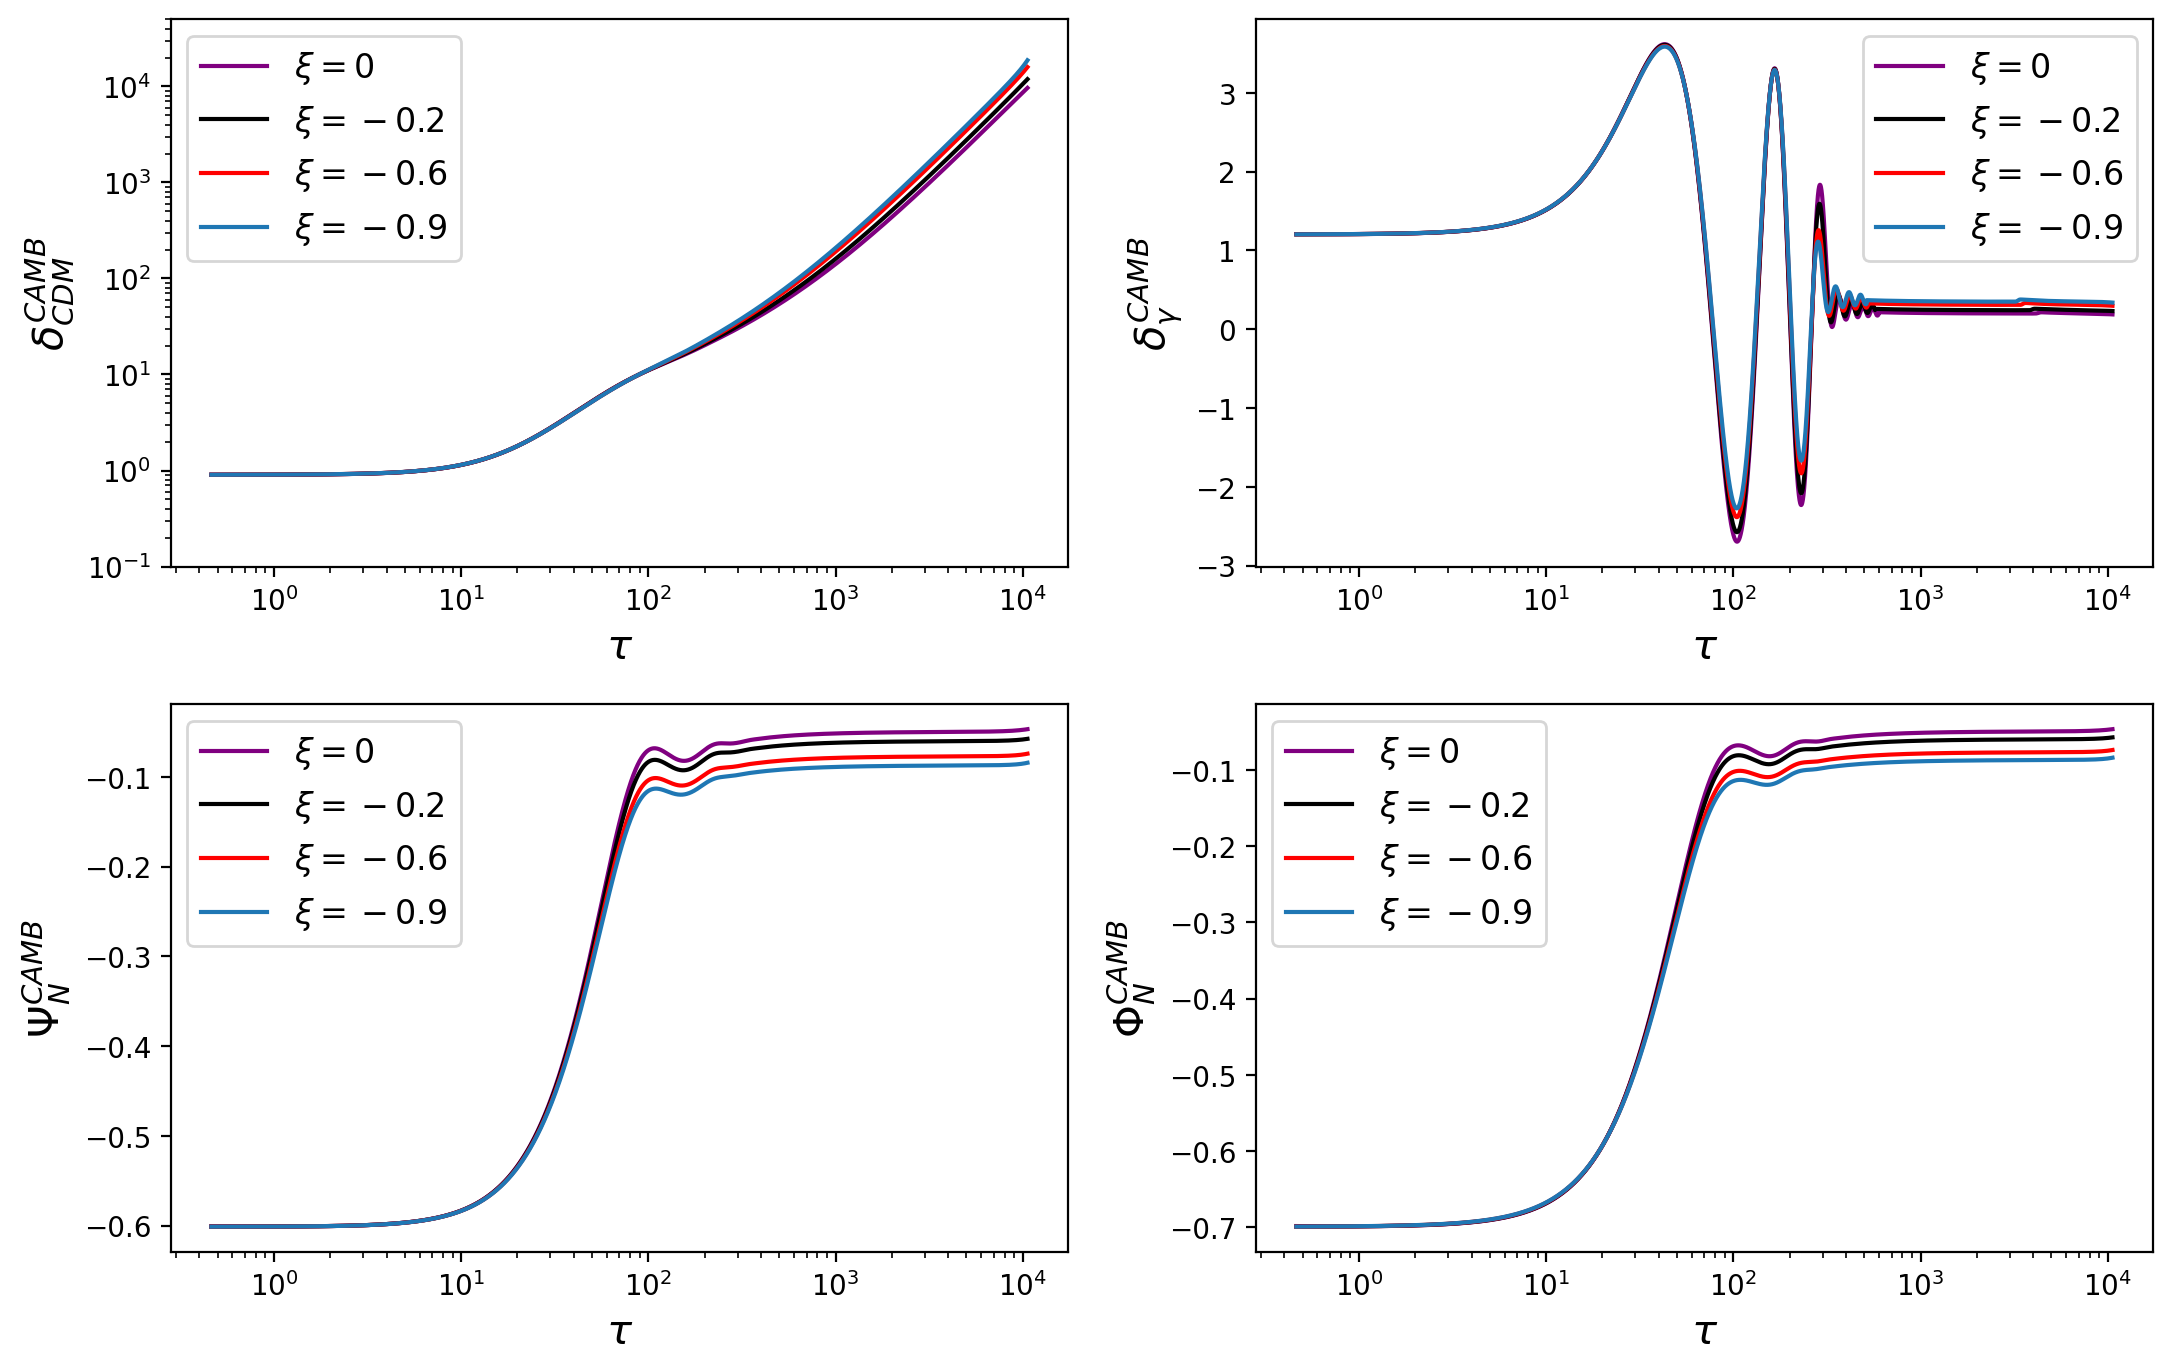

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))

# TIME LIMITS
tau_early_camb = max(tau_early_camb0, tau_early_camb1, tau_early_camb2, tau_early_camb3)
tau_late_camb  = min(tau_late_camb0 , tau_late_camb1 , tau_late_camb2 , tau_late_camb3) 

# TIME SLICE
tau_camb = np.linspace(tau_early_camb, tau_late_camb, 100000)

# PLOTS
axes[0,0].loglog(tau_camb, delta_cdm_camb0(tau_camb),'purple',ls='-',label=r'$\xi = {}$'.format(xi0))
axes[0,0].loglog(tau_camb, delta_cdm_camb1(tau_camb),'black' ,ls='-',label=r'$\xi = {}$'.format(xi1))
axes[0,0].loglog(tau_camb, delta_cdm_camb2(tau_camb),'red'   ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[0,0].loglog(tau_camb, delta_cdm_camb3(tau_camb),'C0'    ,ls='-',label=r'$\xi = {}$'.format(xi3))

axes[0,1].semilogx(tau_camb, delta_pho_camb0(tau_camb),'purple',ls='-',label=r'$\xi = {}$'.format(xi0))
axes[0,1].semilogx(tau_camb, delta_pho_camb1(tau_camb),'black' ,ls='-',label=r'$\xi = {}$'.format(xi1))
axes[0,1].semilogx(tau_camb, delta_pho_camb2(tau_camb),'red'   ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[0,1].semilogx(tau_camb, delta_pho_camb3(tau_camb),'C0'    ,ls='-',label=r'$\xi = {}$'.format(xi3))

axes[1,0].semilogx(tau_camb, psi_n_camb0(tau_camb),'purple',ls='-',label=r'$\xi = {}$'.format(xi0))
axes[1,0].semilogx(tau_camb, psi_n_camb1(tau_camb),'black' ,ls='-',label=r'$\xi = {}$'.format(xi1))
axes[1,0].semilogx(tau_camb, psi_n_camb2(tau_camb),'red'   ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[1,0].semilogx(tau_camb, psi_n_camb3(tau_camb),'C0'    ,ls='-',label=r'$\xi = {}$'.format(xi3))

axes[1,1].semilogx(tau_camb, phi_n_camb0(tau_camb),'purple',ls='-',label=r'$\xi = {}$'.format(xi0))
axes[1,1].semilogx(tau_camb, phi_n_camb1(tau_camb),'black' ,ls='-',label=r'$\xi = {}$'.format(xi1))
axes[1,1].semilogx(tau_camb, phi_n_camb2(tau_camb),'red'   ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[1,1].semilogx(tau_camb, phi_n_camb3(tau_camb),'C0'    ,ls='-',label=r'$\xi = {}$'.format(xi3))

# LABELS
axes[0,0].legend(loc='best',fontsize=12)
axes[0,0].set_ylim(1e-1,5e4)
axes[0,0].set_xlabel(r'$\tau$',fontsize=15)
axes[0,0].set_ylabel(r'$\delta_{CDM}^{CAMB}$',fontsize=15)

axes[0,1].legend(loc='best',fontsize=12)
axes[0,1].set_xlabel(r'$\tau$',fontsize=15)
axes[0,1].set_ylabel(r'$\delta_{\gamma}^{CAMB}$',fontsize=15)

axes[1,0].legend(loc='best',fontsize=12)
axes[1,0].set_xlabel(r'$\tau$',fontsize=15)
axes[1,0].set_ylabel(r'$\Psi_N^{CAMB}$',fontsize=15)

axes[1,1].legend(loc='best',fontsize=12)
axes[1,1].set_xlabel(r'$\tau$',fontsize=15)
axes[1,1].set_ylabel(r'$\Phi_N^{CAMB}$',fontsize=15)
fig.tight_layout();

### CLASS: CDM, PHOTONS and METRIC PERTURBATION

In [11]:
def PERTURBATION_CLASS(xi):
    if xi == 0:
        w = -.9
    elif xi < 0:
        w = -0.999    
    
    class_result = CLASS_FUNC(h, omega_b, omega_cdm, As, ns, tau, xi, w)
    
    # Perturbation part
    tau_per_class       = class_result[0]['scalar'][0]['tau [Mpc]']
    tau_early_per_class = tau_per_class[0]
    tau_late_per_class  = tau_per_class[-1]
    
    delta_cdm_class     = class_result[0]['scalar'][0]['delta_cdm']
    delta_pho_class     = class_result[0]['scalar'][0]['delta_g']    
    delta_rho_fld_class = class_result[0]['scalar'][0]['delta_rho_fld']
    psi_n_class         = class_result[0]['scalar'][0]['psi']
    phi_n_class         = class_result[0]['scalar'][0]['phi']    
    
    delta_cdm_interpol_class     = interp1d(tau_per_class, delta_cdm_class)
    delta_pho_interpol_class     = interp1d(tau_per_class, delta_pho_class)
    delta_rho_fld_interpol_class = interp1d(tau_per_class, delta_rho_fld_class)
    psi_n_interpol_class         = interp1d(tau_per_class, psi_n_class)
    phi_n_interpol_class         = interp1d(tau_per_class, phi_n_class)    
    
    # Background part
    tau_bg_class        = class_result[1]
    tau_early_bg_class  = tau_bg_class[0]
    tau_late_bg_class   = tau_bg_class[-1]
    rho_cdm_bg          = class_result[2]
    rho_fld_bg          = class_result[3]
    rho_fld_bg_interpol = interp1d(tau_bg_class, rho_fld_bg)
    
    # Time slice
    tau_early_class = max(tau_early_per_class, tau_early_bg_class)
    tau_late_class  = min(tau_late_per_class, tau_late_bg_class)    
    tau_common_class = np.linspace(tau_early_class,tau_late_class,100000)
    
    # Delta_fld
    delta_fld_class = delta_rho_fld_interpol_class(tau_common_class) / rho_fld_bg_interpol(tau_common_class)
    delta_fld_interpol_class = interp1d(tau_common_class, delta_fld_class)
    
    return delta_cdm_interpol_class, delta_pho_interpol_class,\
           delta_fld_interpol_class,\
           psi_n_interpol_class, phi_n_interpol_class,\
           tau_early_class, tau_late_class

In [12]:
# COUPLED
xi1 = -.2
perturbation_xi1_class = PERTURBATION_CLASS(xi1)
for i in range(0,7): vars()[perturbation_name[i]+'_class1'] = perturbation_xi1_class[i]

# COUPLED
xi2 = -0.6
perturbation_xi2_class = PERTURBATION_CLASS(xi2)
for i in range(0,7): vars()[perturbation_name[i]+'_class2'] = perturbation_xi2_class[i]

# COUPLED
xi3 = -0.9
perturbation_xi3_class = PERTURBATION_CLASS(xi3)
for i in range(0,7): vars()[perturbation_name[i]+'_class3'] = perturbation_xi3_class[i]

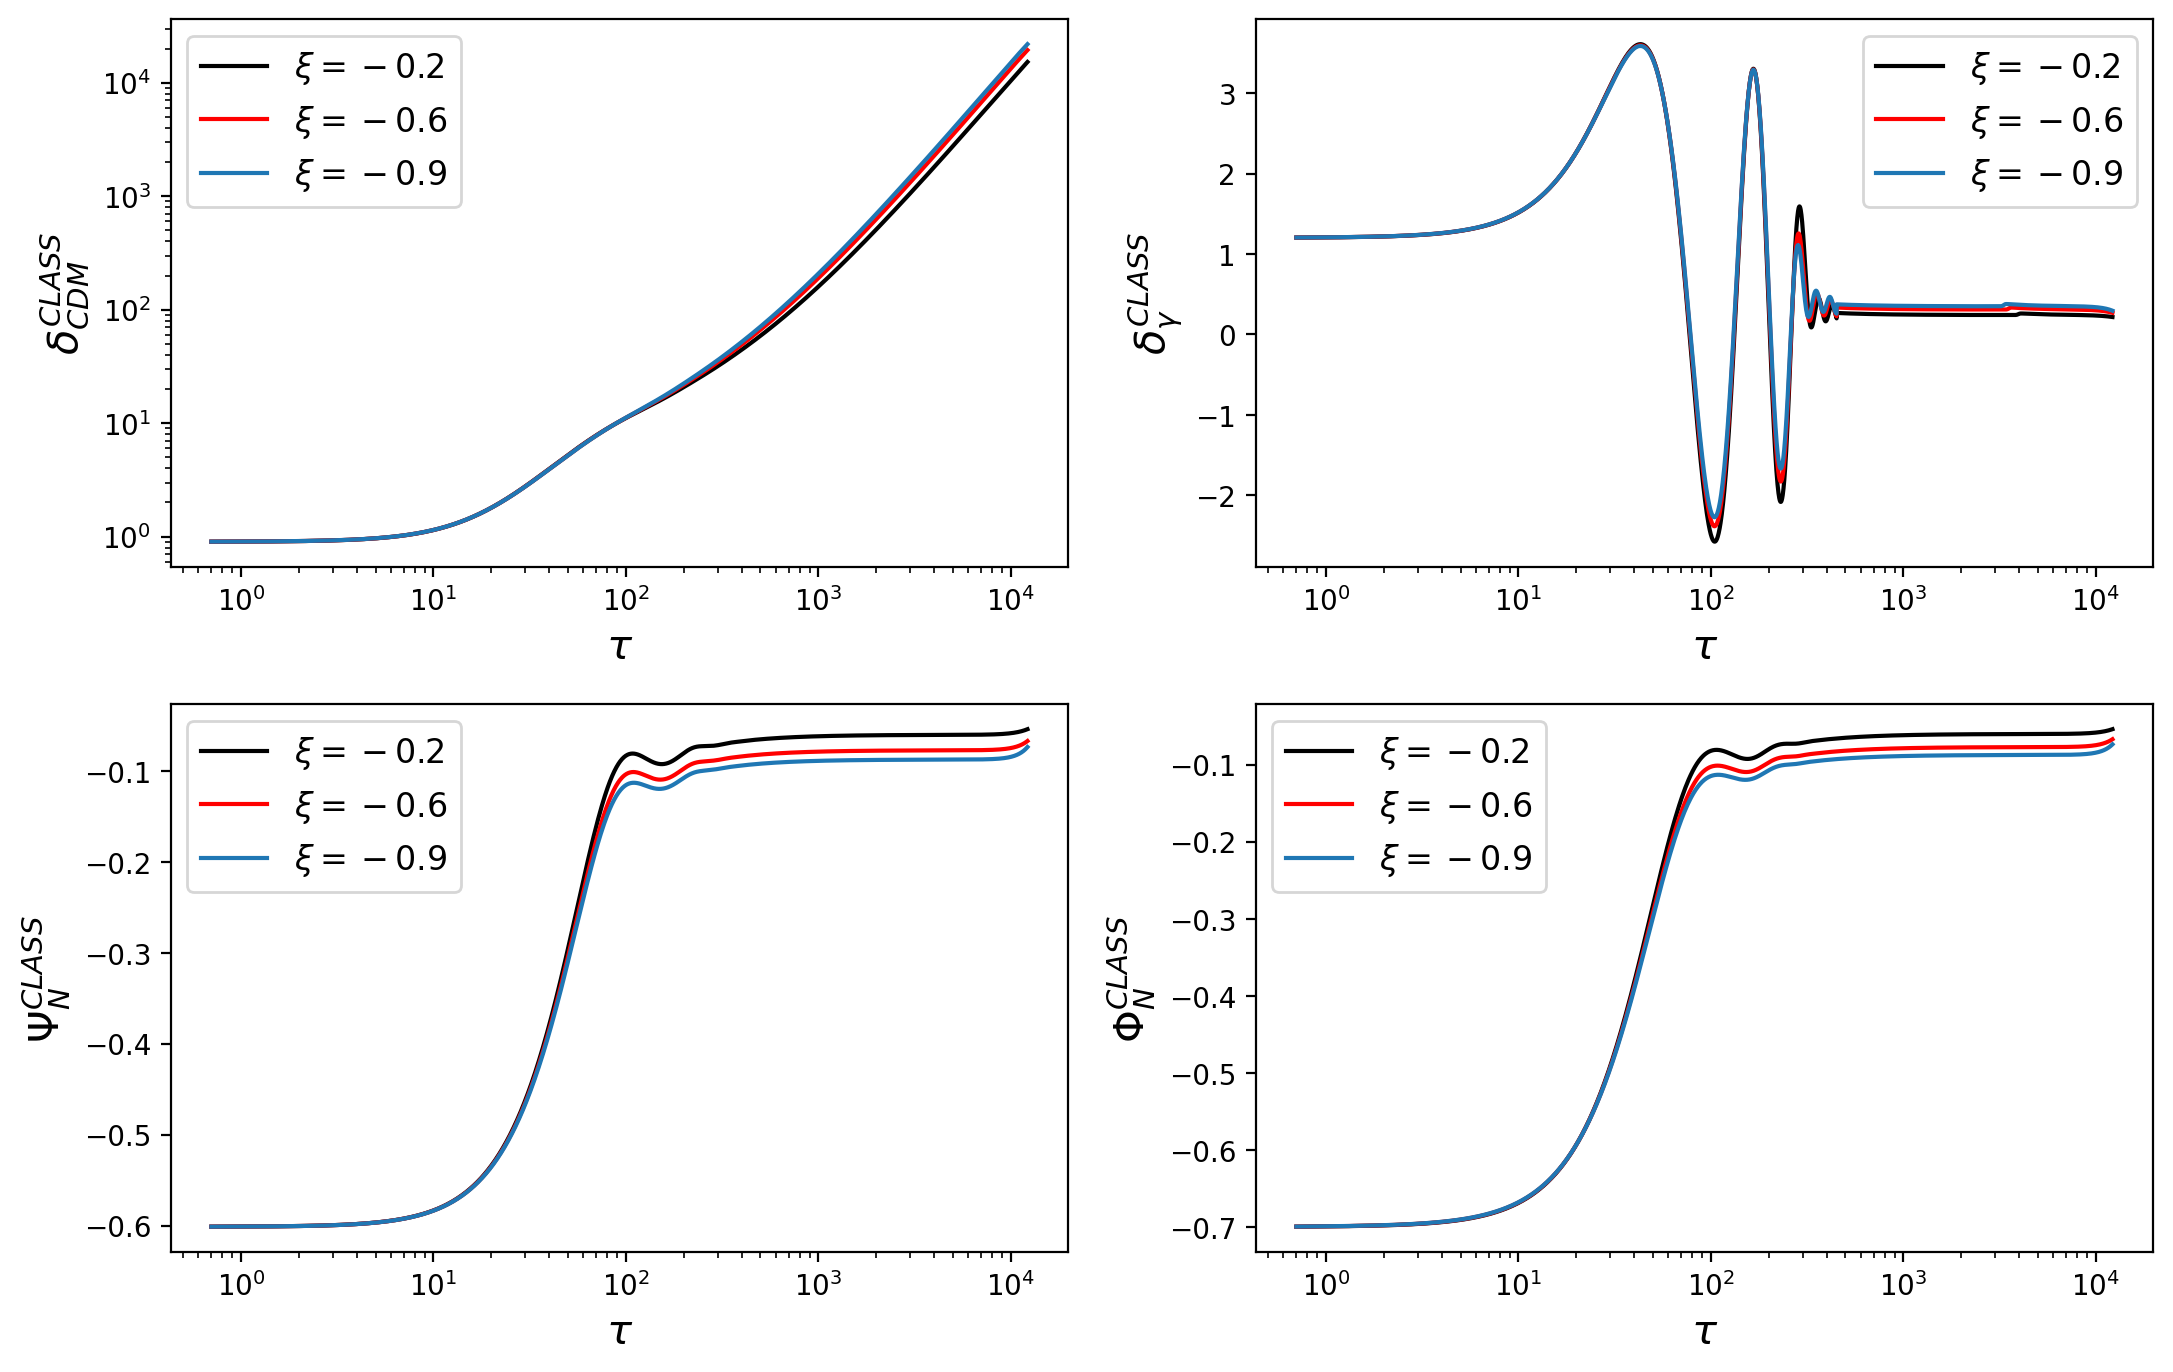

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))

# TIME LIMITS
tau_early_class = max(tau_early_class1, tau_early_class2, tau_early_class3)
tau_late_class  = min(tau_late_class1, tau_late_class2, tau_late_class3) 

# TIME SLICE
tau_class = np.linspace(tau_early_class, tau_late_class, 100000)

# PLOTS
axes[0,0].loglog(tau_class, -delta_cdm_class1(tau_class),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[0,0].loglog(tau_class, -delta_cdm_class2(tau_class),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[0,0].loglog(tau_class, -delta_cdm_class3(tau_class),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

axes[0,1].semilogx(tau_class, -delta_pho_class1(tau_class),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[0,1].semilogx(tau_class, -delta_pho_class2(tau_class),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[0,1].semilogx(tau_class, -delta_pho_class3(tau_class),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

axes[1,0].semilogx(tau_class, -psi_n_class1(tau_class),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[1,0].semilogx(tau_class, -psi_n_class2(tau_class),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[1,0].semilogx(tau_class, -psi_n_class3(tau_class),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

axes[1,1].semilogx(tau_class, -phi_n_class1(tau_class),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[1,1].semilogx(tau_class, -phi_n_class2(tau_class),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[1,1].semilogx(tau_class, -phi_n_class3(tau_class),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

# LABELS
axes[0,0].legend(loc='best',fontsize=12)
axes[0,0].set_xlabel(r'$\tau$',fontsize=15)
axes[0,0].set_ylabel(r'$\delta_{CDM}^{CLASS}$',fontsize=15)

axes[0,1].legend(loc='best',fontsize=12)
axes[0,1].set_xlabel(r'$\tau$',fontsize=15)
axes[0,1].set_ylabel(r'$\delta_{\gamma}^{CLASS}$',fontsize=15)

axes[1,0].legend(loc='best',fontsize=12)
axes[1,0].set_xlabel(r'$\tau$',fontsize=15)
axes[1,0].set_ylabel(r'$\Psi_{N}^{CLASS}$',fontsize=15)

axes[1,1].legend(loc='best',fontsize=12)
axes[1,1].set_xlabel(r'$\tau$',fontsize=15)
axes[1,1].set_ylabel(r'$\Phi_{N}^{CLASS}$',fontsize=15)
fig.tight_layout();

### CAMB vs CLASS: CDM, PHOTONS and METRIC PERTURBATION

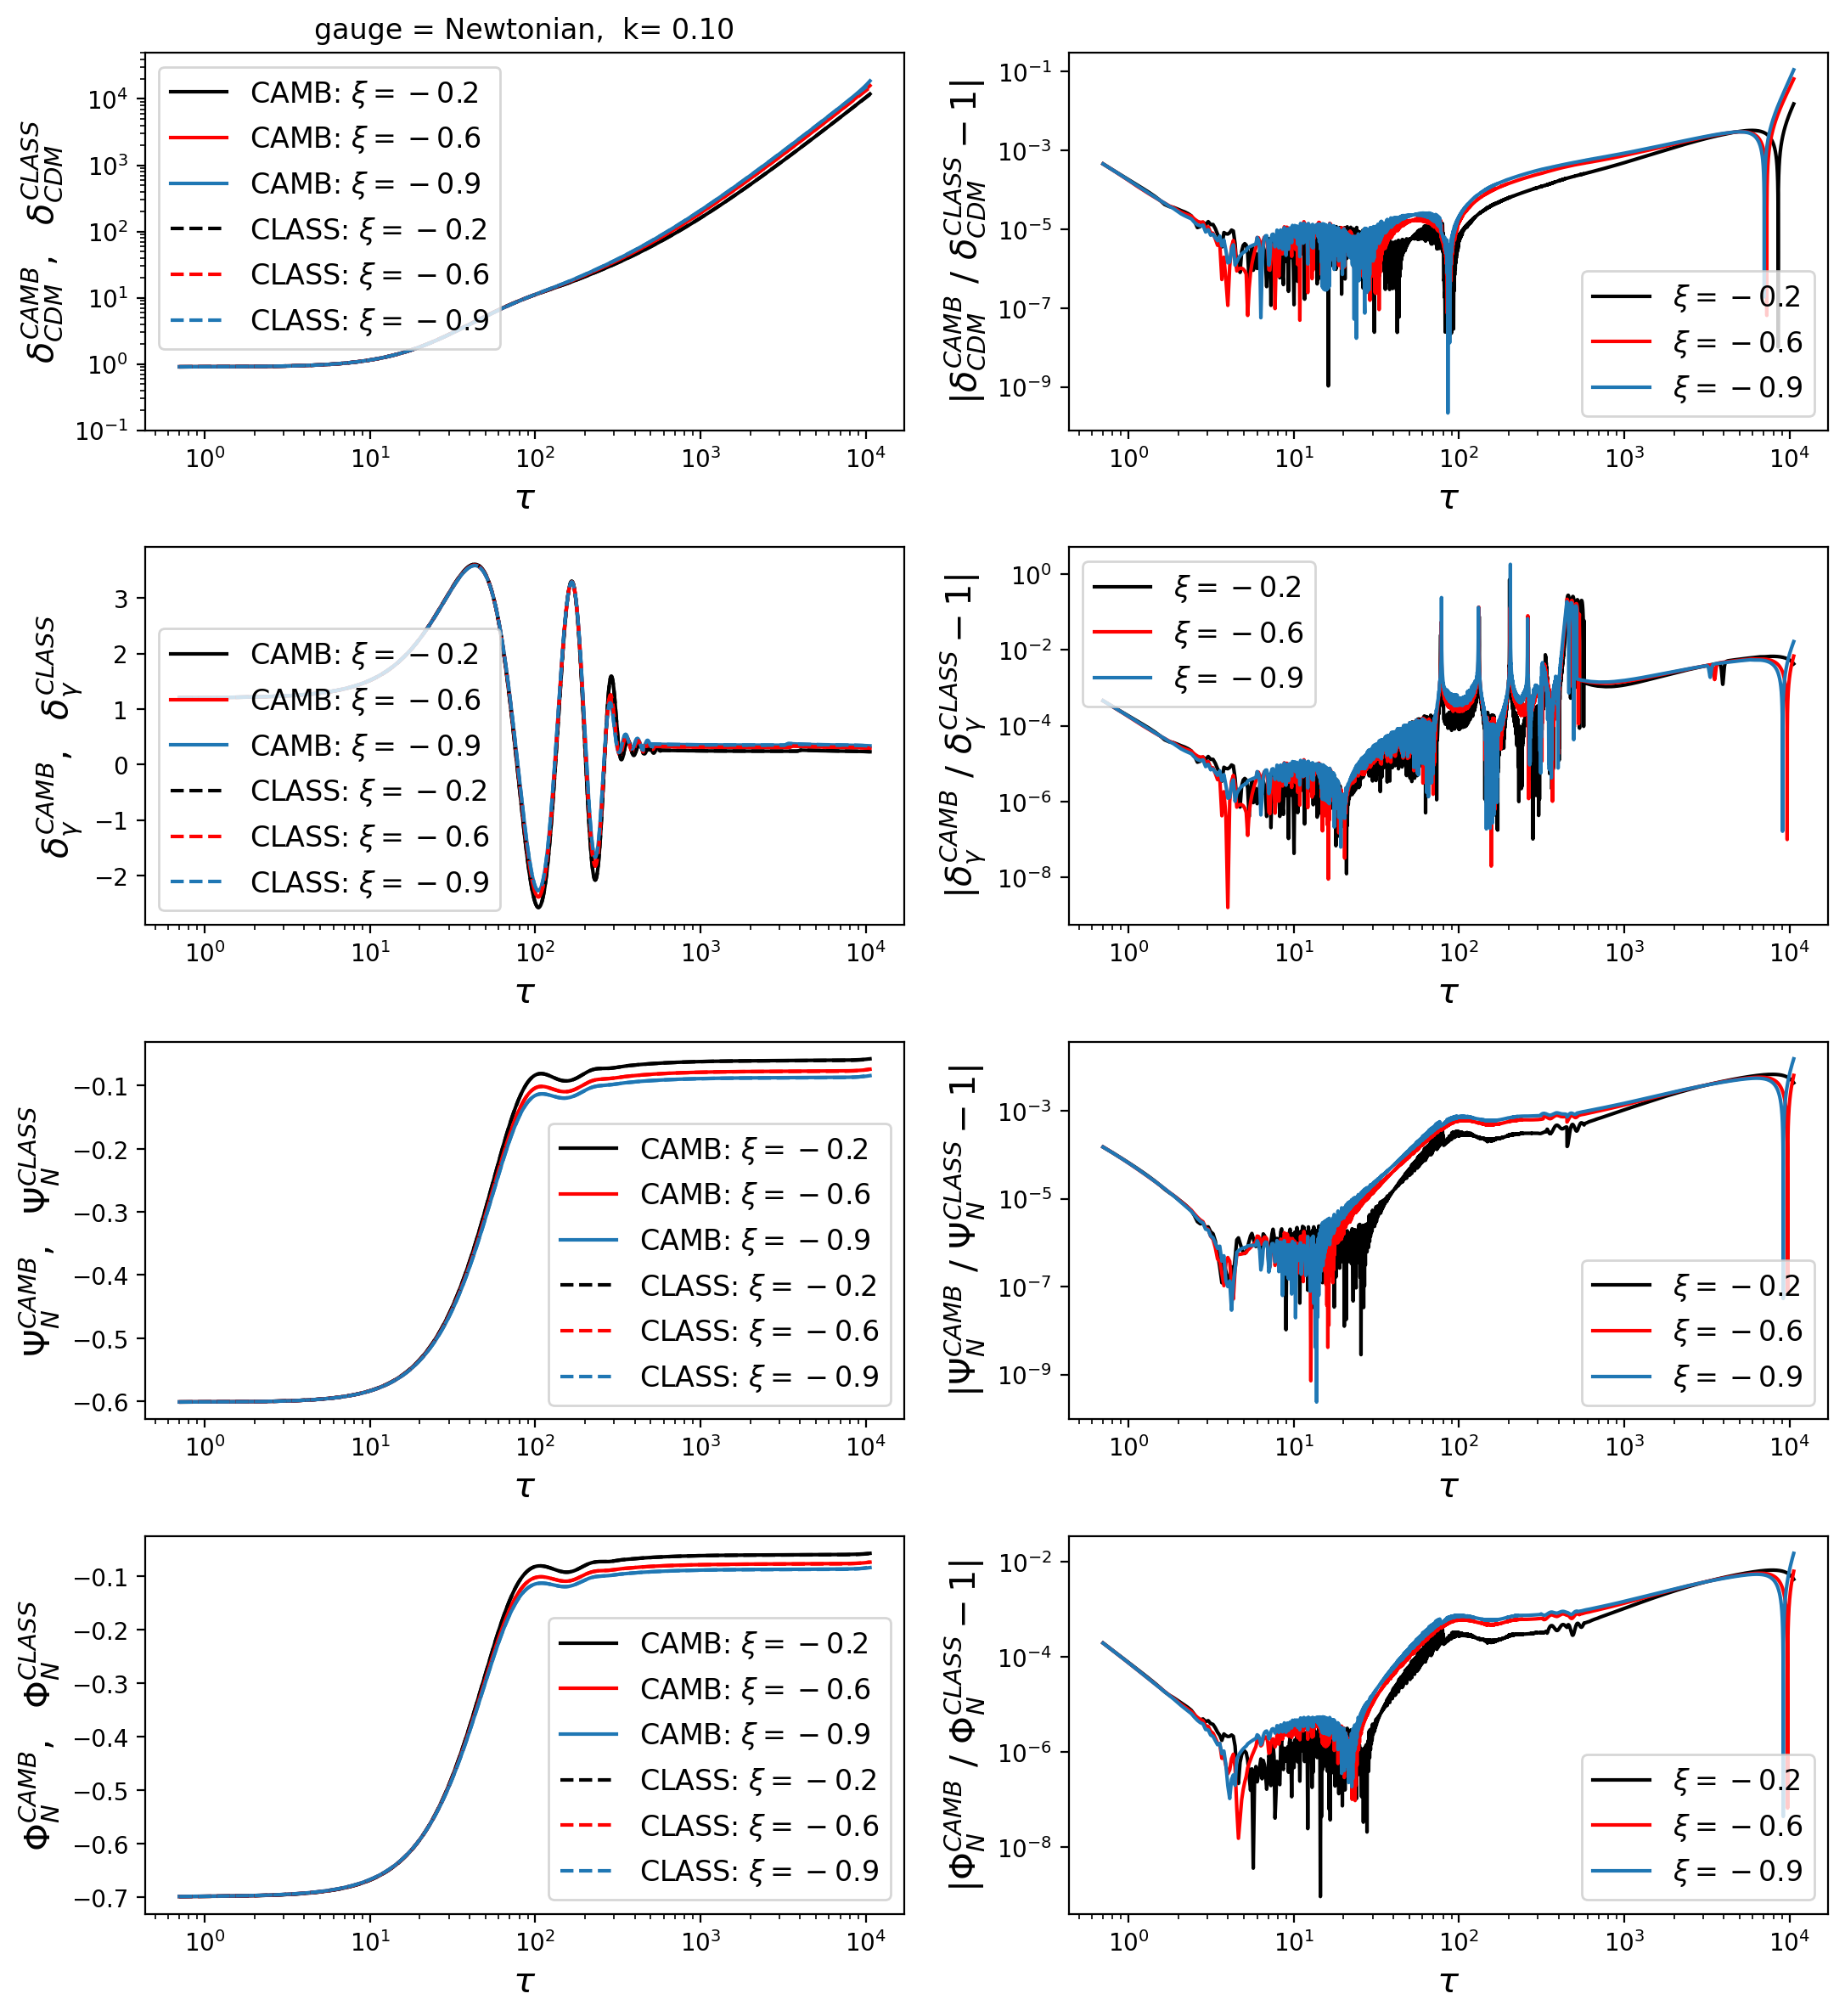

In [14]:
# DEFINING THE SAME TIME SLICE
tau_early_common = max(tau_camb[0],tau_class[0])
tau_late_common  = min(tau_camb[-1],tau_class[-1])
tau_common = np.linspace(tau_early_common, tau_late_common, 100000)

# PLOT
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 12))

# CDM
diff1_cdm = ( delta_cdm_camb1(tau_common) - (-delta_cdm_class1(tau_common)) ) / (-delta_cdm_class1(tau_common))
diff2_cdm = ( delta_cdm_camb2(tau_common) - (-delta_cdm_class2(tau_common)) ) / (-delta_cdm_class2(tau_common))
diff3_cdm = ( delta_cdm_camb3(tau_common) - (-delta_cdm_class3(tau_common)) ) / (-delta_cdm_class3(tau_common))

axes[0,0].loglog(tau_common, delta_cdm_camb1(tau_common),'black' ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi1))
axes[0,0].loglog(tau_common, delta_cdm_camb2(tau_common),'red'   ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi2))
axes[0,0].loglog(tau_common, delta_cdm_camb3(tau_common),'C0'    ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi3))

axes[0,0].loglog(tau_common, -delta_cdm_class1(tau_common),'black',ls='--',label=r'CLASS: $\xi = {}$'.format(xi1))
axes[0,0].loglog(tau_common, -delta_cdm_class2(tau_common),'red'  ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi2))
axes[0,0].loglog(tau_common, -delta_cdm_class3(tau_common),'C0'   ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi3))

axes[0,1].loglog(tau_common, abs(diff1_cdm),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[0,1].loglog(tau_common, abs(diff2_cdm),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[0,1].loglog(tau_common, abs(diff3_cdm),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

# PHOTONS
diff1_pho = ( delta_pho_camb1(tau_common) - (-delta_pho_class1(tau_common)) ) / (-delta_pho_class1(tau_common))
diff2_pho = ( delta_pho_camb2(tau_common) - (-delta_pho_class2(tau_common)) ) / (-delta_pho_class2(tau_common))
diff3_pho = ( delta_pho_camb3(tau_common) - (-delta_pho_class3(tau_common)) ) / (-delta_pho_class3(tau_common))

axes[1,0].semilogx(tau_common, delta_pho_camb1(tau_common),'black' ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi1))
axes[1,0].semilogx(tau_common, delta_pho_camb2(tau_common),'red'   ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi2))
axes[1,0].semilogx(tau_common, delta_pho_camb3(tau_common),'C0'    ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi3))

axes[1,0].semilogx(tau_common, -delta_pho_class1(tau_common),'black',ls='--',label=r'CLASS: $\xi = {}$'.format(xi1))
axes[1,0].semilogx(tau_common, -delta_pho_class2(tau_common),'red'  ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi2))
axes[1,0].semilogx(tau_common, -delta_pho_class3(tau_common),'C0'   ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi3))

axes[1,1].loglog(tau_common, abs(diff1_pho),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[1,1].loglog(tau_common, abs(diff2_pho),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[1,1].loglog(tau_common, abs(diff3_pho),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

# PSI_N
diff1_psi_n = ( psi_n_camb1(tau_common) - (-psi_n_class1(tau_common)) ) / (-psi_n_class1(tau_common))
diff2_psi_n = ( psi_n_camb2(tau_common) - (-psi_n_class2(tau_common)) ) / (-psi_n_class2(tau_common))
diff3_psi_n = ( psi_n_camb3(tau_common) - (-psi_n_class3(tau_common)) ) / (-psi_n_class3(tau_common))

axes[2,0].semilogx(tau_common, psi_n_camb1(tau_common),'black' ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi1))
axes[2,0].semilogx(tau_common, psi_n_camb2(tau_common),'red'   ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi2))
axes[2,0].semilogx(tau_common, psi_n_camb3(tau_common),'C0'    ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi3))

axes[2,0].semilogx(tau_common, -psi_n_class1(tau_common),'black',ls='--',label=r'CLASS: $\xi = {}$'.format(xi1))
axes[2,0].semilogx(tau_common, -psi_n_class2(tau_common),'red'  ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi2))
axes[2,0].semilogx(tau_common, -psi_n_class3(tau_common),'C0'   ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi3))

axes[2,1].loglog(tau_common, abs(diff1_psi_n),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[2,1].loglog(tau_common, abs(diff2_psi_n),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[2,1].loglog(tau_common, abs(diff3_psi_n),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

# PHI_N
diff1_phi_n = ( phi_n_camb1(tau_common) - (-phi_n_class1(tau_common)) ) / (-phi_n_class1(tau_common))
diff2_phi_n = ( phi_n_camb2(tau_common) - (-phi_n_class2(tau_common)) ) / (-phi_n_class2(tau_common))
diff3_phi_n = ( phi_n_camb3(tau_common) - (-phi_n_class3(tau_common)) ) / (-phi_n_class3(tau_common))

axes[3,0].semilogx(tau_common, phi_n_camb1(tau_common),'black' ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi1))
axes[3,0].semilogx(tau_common, phi_n_camb2(tau_common),'red'   ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi2))
axes[3,0].semilogx(tau_common, phi_n_camb3(tau_common),'C0'    ,ls='-',label=r'CAMB: $\xi = {}$'.format(xi3))

axes[3,0].semilogx(tau_common, -phi_n_class1(tau_common),'black',ls='--',label=r'CLASS: $\xi = {}$'.format(xi1))
axes[3,0].semilogx(tau_common, -phi_n_class2(tau_common),'red'  ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi2))
axes[3,0].semilogx(tau_common, -phi_n_class3(tau_common),'C0'   ,ls='--',label=r'CLASS: $\xi = {}$'.format(xi3))

axes[3,1].loglog(tau_common, abs(diff1_phi_n),'black',ls='-',label=r'$\xi = {}$'.format(xi1))
axes[3,1].loglog(tau_common, abs(diff2_phi_n),'red'  ,ls='-',label=r'$\xi = {}$'.format(xi2))
axes[3,1].loglog(tau_common, abs(diff3_phi_n),'C0'   ,ls='-',label=r'$\xi = {}$'.format(xi3))

# AXES CONFIGURATIONS
axes[0,0].set_title('gauge = %s'%gauge+',  k= %.2f'%kscale)
axes[0,0].legend(loc='best',fontsize=12)
axes[0,1].legend(loc='best',fontsize=12)
axes[0,0].set_ylim(1e-1,5e4)
axes[0,0].set_xlabel(r'$\tau$',fontsize=15)
axes[0,1].set_xlabel(r'$\tau$',fontsize=15)
axes[0,0].set_ylabel(r'$\delta_{CDM}^{CAMB},~~\delta_{CDM}^{CLASS}$',fontsize=15)
axes[0,1].set_ylabel(r'$|\delta_{CDM}^{CAMB}~/~\delta_{CDM}^{CLASS} - 1|$',fontsize=15)

axes[1,0].legend(loc='best',fontsize=12)
axes[1,1].legend(loc='best',fontsize=12)
axes[1,0].set_xlabel(r'$\tau$',fontsize=15)
axes[1,1].set_xlabel(r'$\tau$',fontsize=15)
axes[1,0].set_ylabel(r'$\delta_{\gamma}^{CAMB},~~\delta_{\gamma}^{CLASS}$',fontsize=15)
axes[1,1].set_ylabel(r'$|\delta_{\gamma}^{CAMB}~/~\delta_{\gamma}^{CLASS} - 1|$',fontsize=15)

axes[2,0].legend(loc='best',fontsize=12)
axes[2,1].legend(loc='best',fontsize=12)
axes[2,0].set_xlabel(r'$\tau$',fontsize=15)
axes[2,1].set_xlabel(r'$\tau$',fontsize=15)
axes[2,0].set_ylabel(r'$\Psi_{N}^{CAMB},~~\Psi_{N}^{CLASS}$',fontsize=15)
axes[2,1].set_ylabel(r'$|\Psi_{N}^{CAMB}~/~\Psi_{N}^{CLASS} - 1|$',fontsize=15)

axes[3,0].legend(loc='best',fontsize=12)
axes[3,1].legend(loc='best',fontsize=12)
axes[3,0].set_xlabel(r'$\tau$',fontsize=15)
axes[3,1].set_xlabel(r'$\tau$',fontsize=15)
axes[3,0].set_ylabel(r'$\Phi_{N}^{CAMB},~~\Phi_{N}^{CLASS}$',fontsize=15)
axes[3,1].set_ylabel(r'$|\Phi_{N}^{CAMB}~/~\Phi_{N}^{CLASS} - 1|$',fontsize=15)
fig.tight_layout();